In [ ]:
import numpy as np
import torch
import torch.nn as nn

sparsity_level = 15

problem_file = np.load(f"../problems/prob_{sparsity_level}_noiseless.npz")

problem_file.files

['A', 'M', 'N', 'L', 'pnz', 'SNR', 'con_num', 'y', 'x']

In [120]:
x_signal = problem_file['x']
y_measurement = problem_file['y']
A_system = problem_file['A']

In [121]:
A_system.shape, x_signal.shape, y_measurement.shape

((250, 500), (500, 1000), (250, 1000))

In [122]:
# 1. Convert to Torch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

A = torch.from_numpy(A_system).float().to(device)  # (250, 500)
y = torch.from_numpy(y_measurement).float().to(device)  # (250, 1000)
x_real = torch.from_numpy(x_signal).float().to(device)  # (500,)

mse_loss = nn.MSELoss(reduction="sum").to(device)

# Problem dimensions
m, n = A.shape
_, batch_size = y.shape

# Helper: matrix-vector multiply for batched signals
def matvec(A, x):
    return A @ x

def matvec_T(A, y):
    return A.T @ y

# 2. Solvers

def gradient_descent(x_real, A, y, lam=1e-3, num_iters=500, step_size=1e-3):
    x = torch.zeros((n, batch_size), device=device)
    losses_m = []
    losses_r = []
    for i in range(num_iters):
        grad = matvec_T(A, matvec(A, x) - y)
        x = x - step_size * grad

        # Compute loss
        residual = matvec(A, x) - y
        loss = 0.5 * (residual**2).sum(dim=0).mean() + lam * x.abs().sum(dim=0).mean()
        losses_m.append(loss.item())
        losses_r.append(mse_loss(x, x_real).item())
    return x, losses_m, losses_r

def gradient_descent_pinv(x_real, A, y, lam=1e-3, num_iters=500, step_size=1e-3):
    x = torch.zeros((n, batch_size), device=device)
    losses_m = []
    losses_r = []
    for i in range(num_iters):
        grad = A.T @ torch.inverse(A@A.T) @ (A @ x - y)
        x = x - step_size * grad

        # Compute loss
        residual = matvec(A, x) - y
        loss = 0.5 * (residual**2).sum(dim=0).mean() + lam * x.abs().sum(dim=0).mean()
        losses_m.append(loss.item())
        losses_r.append(mse_loss(x, x_real).item())
    return x, losses_m, losses_r

def ista(x_real, A, y, lam=1e-3, num_iters=500, step_size=1e-3):
    x = torch.zeros((n, batch_size), device=device)
    losses_m = []
    losses_r = []
    for i in range(num_iters):
        grad = matvec_T(A, matvec(A, x) - y)
        x = x - step_size * grad
        x = torch.sign(x) * torch.relu(torch.abs(x) - lam * step_size)

        # Compute loss
        residual = matvec(A, x) - y
        loss = 0.5 * (residual**2).sum(dim=0).mean() + lam * x.abs().sum(dim=0).mean()
        losses_m.append(loss.item())
        losses_r.append(mse_loss(x, x_real).item())
    return x, losses_m, losses_r

def ista_pinv(x_real, A, y, lam=1e-3, num_iters=500, step_size=1e-3):
    x = torch.zeros((n, batch_size), device=device)
    losses_m = []
    losses_r = []
    for i in range(num_iters):
        # grad = matvec_T(A, matvec(A, x) - y)
        grad = A.T @ torch.inverse(A@A.T) @ (A @ x - y)
        x = x - step_size * grad
        x = torch.sign(x) * torch.relu(torch.abs(x) - lam * step_size)

        # Compute loss
        residual = matvec(A, x) - y
        loss = 0.5 * (residual**2).sum(dim=0).mean() + lam * x.abs().sum(dim=0).mean()
        losses_m.append(loss.item())
        losses_r.append(mse_loss(x, x_real).item())
    return x, losses_m, losses_r

def fista(x_real, A, y, lam=1e-3, num_iters=500, step_size=1e-3):
    x = torch.zeros((n, batch_size), device=device)
    z = x.clone()
    t = torch.tensor(1)
    losses_m = []
    losses_r = []
    for i in range(num_iters):
        grad = matvec_T(A, matvec(A, z) - y)
        # grad = A.T @ torch.inverse(A@A.T) @ (A @ x - y)
        x_next = z - step_size * grad
        x_next = torch.sign(x_next) * torch.relu(torch.abs(x_next) - lam * step_size)

        t_next = (1 + (1 + 4 * t**2).sqrt()) / 2
        z = x_next + ((t - 1) / t_next) * (x_next - x)

        x = x_next
        t = t_next

        # Compute loss
        residual = matvec(A, x) - y
        loss = 0.5 * (residual**2).sum(dim=0).mean() + lam * x.abs().sum(dim=0).mean()
        losses_m.append(loss.item())
        losses_r.append(mse_loss(x, x_real).item())
    return x, losses_m, losses_r


def fista_pinv(x_real, A, y, lam=1e-3, num_iters=500, step_size=1e-3):
    x = torch.zeros((n, batch_size), device=device)
    z = x.clone()
    t = torch.tensor(1)
    losses_m = []
    losses_r = []
    for i in range(num_iters):
        # grad = matvec_T(A, matvec(A, z) - y)
        grad = A.T @ torch.inverse(A@A.T) @ (A @ x - y)
        x_next = z - step_size * grad
        x_next = torch.sign(x_next) * torch.relu(torch.abs(x_next) - lam * step_size)

        t_next = (1 + (1 + 4 * t**2).sqrt()) / 2
        z = x_next + ((t - 1) / t_next) * (x_next - x)

        x = x_next
        t = t_next

        # Compute loss
        residual = matvec(A, x) - y
        loss = 0.5 * (residual**2).sum(dim=0).mean() + lam * x.abs().sum(dim=0).mean()
        losses_m.append(loss.item())
        losses_r.append(mse_loss(x, x_real).item())
    return x, losses_m, losses_r



In [123]:
import matplotlib.pyplot as plt


# Estimate a good step size by 1 / (Lipschitz constant of A^T A)
L = torch.linalg.norm(A, ord=2)**2  # Largest singular value squared
step_size = 1.0 / L
# step_size = 0.25

# Run
x_gd, gd_losses_m, gd_losses_r = gradient_descent(x_real, A, y, lam=1e-2, num_iters=500, step_size=step_size)
x_ista, ista_losses_m, ista_losses_r = ista(x_real, A, y, lam=1e-2, num_iters=500, step_size=step_size)
x_fista, fista_losses_m, fista_losses_r = fista(x_real, A, y, lam=1e-2, num_iters=500, step_size=step_size)

# 4. (Optional) Evaluate recovery quality against ground truth
# Only if x_signal is available
x_true = torch.from_numpy(x_signal).float().to(device)

def recovery_error(x_rec, x_true):
    return ((x_rec - x_true)**2).mean().item()

print("Gradient Descent Recovery Error:", recovery_error(x_gd, x_true))
print("ISTA Recovery Error:", recovery_error(x_ista, x_true))
print("FISTA Recovery Error:", recovery_error(x_fista, x_true))

Gradient Descent Recovery Error: 0.07498481869697571
ISTA Recovery Error: 0.016358738765120506
FISTA Recovery Error: 0.00022149049618747085


In [124]:
A_pinv = torch.linalg.pinv(A)
A_proj = A_pinv @ A
L = torch.linalg.norm(A_proj, ord=2)
step_size_pinv = 1.0 / L

# Run pinv solvers
x_gd_pinv, gd_losses_m_pinv, gd_losses_r_pinv = gradient_descent_pinv(x_real, A, y, lam=1e-2, num_iters=500, step_size=step_size_pinv)
x_ista_pinv, ista_losses_m_pinv, ista_losses_r_pinv = ista_pinv(x_real, A, y, lam=1e-2, num_iters=500, step_size=step_size_pinv)
x_fista_pinv, fista_losses_m_pinv, fista_losses_r_pinv = fista_pinv(x_real, A, y, lam=1e-2, num_iters=500, step_size=step_size_pinv)

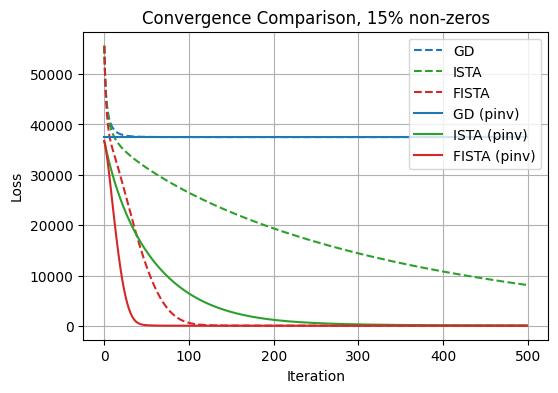

In [125]:
# Plot
plt.figure(figsize=(6,4))
plt.plot(gd_losses_r, '--', label='GD', color='tab:blue')
plt.plot(ista_losses_r, '--', label='ISTA', color='tab:green')
plt.plot(fista_losses_r, '--', label='FISTA', color='tab:red')

plt.plot(gd_losses_r_pinv, label='GD (pinv)', color='tab:blue')
plt.plot(ista_losses_r_pinv, label='ISTA (pinv)', color='tab:green')
plt.plot(fista_losses_r_pinv, label='FISTA (pinv)', color='tab:red')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title(f'Convergence Comparison, {sparsity_level}% non-zeros')
plt.legend()
plt.grid(True)
# plt.ylim([-5000, 60000])
plt.show()

In [134]:
def nmse_db_to_mse(nmse_db_array, energy_x_star):
    """
    Convert an array of NMSE values (in dB) into corresponding E[MSE] values.

    Args:
        nmse_db_array (np.ndarray): Array of NMSE values in dB.
        energy_x_star (float): Expected squared norm of the true signal (E[||x*||^2]).

    Returns:
        np.ndarray: Array of E[MSE] values.
    """
    # Convert NMSE from dB to linear scale
    nmse_linear = 10**(nmse_db_array / 10)

    # Compute expected MSE
    e_mse_array = energy_x_star * nmse_linear

    return e_mse_array

In [138]:
lista_data = np.load("LISTA_T16_lam0.4_t_s_0.npz")
lrn_U_lista_data = np.load("lrn_U_LISTA_T16_lam0.4_t_s_0.npz")
lrn_U_lfista_dat = np.load("lrn_U_LFISTA_m_cpss_T16_lam0.4_p1.2_mp13.0_t_s_0.npz")

lista_losses = nmse_db_to_mse(lista_data['nmse'], np.mean(np.sum(x_signal**2, axis=0))) #* 1000.0
lrn_U_lista_losses = nmse_db_to_mse(lrn_U_lista_data['nmse'], np.mean(np.sum(x_signal**2, axis=0))) #* 1000.0
lrn_U_lfista_losses = nmse_db_to_mse(lrn_U_lfista_dat['nmse'], np.mean(np.sum(x_signal**2, axis=0))) #* 1000.0

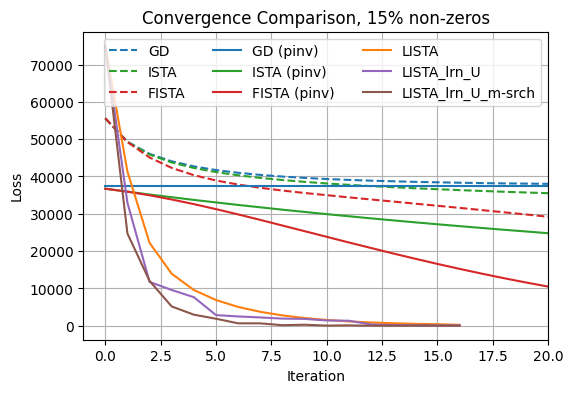

In [148]:
# Plot
plt.figure(figsize=(6,4))
plt.plot(gd_losses_r, '--', label='GD', color='tab:blue')
plt.plot(ista_losses_r, '--', label='ISTA', color='tab:green')
plt.plot(fista_losses_r, '--', label='FISTA', color='tab:red')

plt.plot(gd_losses_r_pinv, label='GD (pinv)', color='tab:blue')
plt.plot(ista_losses_r_pinv, label='ISTA (pinv)', color='tab:green')
plt.plot(fista_losses_r_pinv, label='FISTA (pinv)', color='tab:red')

plt.plot(lista_losses, label='LISTA', color='tab:orange')
plt.plot(lrn_U_lista_losses, label='LISTA_lrn_U', color='tab:purple')
plt.plot(lrn_U_lfista_losses, label='LISTA_lrn_U_m-srch', color='tab:brown')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title(f'Convergence Comparison, {sparsity_level}% non-zeros')
plt.legend(ncol=3)
plt.grid(True)

plt.xlim([-1, 20])
# plt.ylim([-500, 10000])
plt.show()

In [152]:
def mse_to_nmse_db(mse_array, x_star):
    """
    Convert an array of MSE values into NMSE values (in dB),
    given the real signals x_star.

    Args:
        mse_array (np.ndarray): Array of MSE values.
        x_star (np.ndarray): True signals of shape (signal_length, num_samples).

    Returns:
        np.ndarray: Array of NMSE values in dB.
    """
    # Compute expected energy of x_star
    energy_x_star = np.mean(np.sum(x_star**2, axis=0))  # Average over batch

    # Compute NMSE (linear)
    nmse_linear = mse_array / energy_x_star

    # Convert to dB
    nmse_db_array = 10 * np.log10(nmse_linear)

    return nmse_db_array

In [159]:
lista_nmse = lista_data['nmse']
lrn_U_lista_nmse = lrn_U_lista_data['nmse']
lrn_U_lfista_nmse = lrn_U_lfista_dat['nmse']

gd_nmse = mse_to_nmse_db(np.array(gd_losses_r), x_signal)
ista_nmse = mse_to_nmse_db(np.array(ista_losses_r), x_signal)
fista_nmse = mse_to_nmse_db(np.array(fista_losses_r), x_signal)

gd_pinv_nmse = mse_to_nmse_db(np.array(gd_losses_r_pinv), x_signal)
ista_pinv_nmse = mse_to_nmse_db(np.array(ista_losses_r_pinv), x_signal)
fista_pinv_nmse = mse_to_nmse_db(np.array(fista_losses_r_pinv), x_signal)

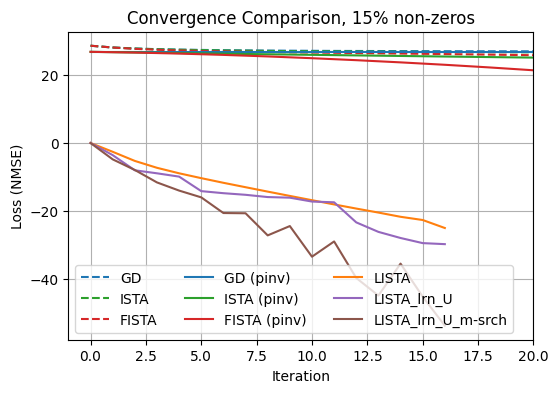

In [160]:
# Plot
plt.figure(figsize=(6,4))
plt.plot(gd_nmse, '--', label='GD', color='tab:blue')
plt.plot(ista_nmse, '--', label='ISTA', color='tab:green')
plt.plot(fista_nmse, '--', label='FISTA', color='tab:red')

plt.plot(gd_pinv_nmse, label='GD (pinv)', color='tab:blue')
plt.plot(ista_pinv_nmse, label='ISTA (pinv)', color='tab:green')
plt.plot(fista_pinv_nmse, label='FISTA (pinv)', color='tab:red')

plt.plot(lista_nmse, label='LISTA', color='tab:orange')
plt.plot(lrn_U_lista_nmse, label='LISTA_lrn_U', color='tab:purple')
plt.plot(lrn_U_lfista_nmse, label='LISTA_lrn_U_m-srch', color='tab:brown')

plt.xlabel('Iteration')
plt.ylabel('Loss (NMSE)')
plt.title(f'Convergence Comparison, {sparsity_level}% non-zeros')
plt.legend(ncol=3)
plt.grid(True)

plt.xlim([-1, 20])
# plt.ylim([-500, 10000])
plt.show()